<a href="https://colab.research.google.com/github/otvet4ikov/different_notebooks/blob/main/%D1%82%D0%B5%D1%81%D1%82_%D1%80%D0%B0%D0%B7%D0%BB%D0%B8%D1%87%D0%BD%D1%8B%D1%85_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80%D0%BE%D0%B2_%D0%B2_%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D0%B5_%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA%D0%B0_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.read_csv('submission.csv')
passangers = test['PassengerId']

In [ ]:
train.shape

(891, 12)

In [ ]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Добавим размер семьи в данные


In [ ]:
train['Family_size'] = train['SibSp'] + train['Parch'] + 1
test['Family_size'] = test['SibSp'] + test['Parch'] + 1

In [ ]:
vals = train.groupby(['Family_size', 'Survived']).agg({'Survived': 'count'})\
.rename(columns={'Survived': 'Survived_count'}).reset_index()
fam = train.groupby('Family_size').agg({'Survived': 'count'}).rename(columns={'Survived': 'Survived_sum'})
vals_fam = vals.merge(fam, on='Family_size')
vals_fam['ratio'] = vals_fam['Survived_count'] / vals_fam['Survived_sum']
vals_fam

,Family_size,Survived,Survived_count,Survived_sum,ratio
0,1,0,374,537,0.696462
1,1,1,163,537,0.303538
2,2,0,72,161,0.447205
3,2,1,89,161,0.552795
4,3,0,43,102,0.421569
5,3,1,59,102,0.578431
6,4,0,8,29,0.275862
7,4,1,21,29,0.724138
8,5,0,12,15,0.800000
9,5,1,3,15,0.200000


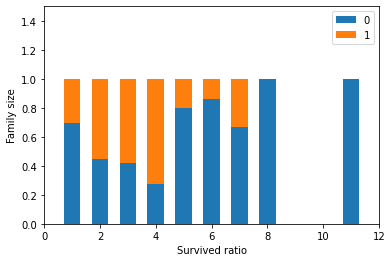

In [ ]:
family_size = np.array(vals_fam['Family_size'].unique())
survived_ratio = pd.concat([vals_fam['Survived'], vals_fam['ratio']], axis = 1)

for size in family_size:
  if vals_fam[vals_fam['Family_size'] == size]['Family_size'].count() == 1:
    if np.array(vals_fam[vals_fam['Family_size'] == size]['Survived'])[0] == 0:
      val = 1
    else:
      print(0)
    vals_fam = vals_fam.append({'Family_size' : size,
                                'Survived' : val,
                                'ratio': 0}, ignore_index=True)
vals_fam = vals_fam.sort_values(by = ['Family_size', 'Survived'])
zero = np.array(vals_fam[vals_fam['Survived'] == 0]['ratio'])
one = np.array(vals_fam[vals_fam['Survived'] == 1]['ratio'])
w = 0.6


plt.bar(family_size, zero, w, label = '0')
plt.bar(family_size, one, w, bottom=zero, label = '1')
plt.xlabel("Survived ratio")
plt.ylabel("Family size")
plt.ylim(0, 1.5)
plt.xlim(0, 12)
plt.legend()

plt.show()

Сделаем плату как категориальный признак


In [ ]:
df = pd.concat([train, test], axis = 0)
df = df.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'PassengerId'], axis = 1)
df['Fare'] = df['Fare'].fillna(df['Fare'].median())



Аналогично для возраста

In [ ]:
age_avg = df['Age'].mean()
age_std = df['Age'].std()
age_null_count = df['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
df['Age'][np.isnan(df['Age'])] = age_null_random_list
df['Age'] = df['Age'].astype(int)

In [ ]:
df.Sex = df.Sex.map({'male' : 0, 'female' : 1})
df['Embarked'] = df['Embarked'].fillna('S')
df['Embarked'] = df['Embarked'].map({'S': 0, 'C' : 1, 'Q' : 2})

In [ ]:
df

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_size
0,0.0,3,0,22,7.2500,0,2
1,1.0,1,1,38,71.2833,1,2
2,1.0,3,1,26,7.9250,0,1
3,1.0,1,1,35,53.1000,0,2
4,0.0,3,0,35,8.0500,0,1
...,...,...,...,...,...,...,...
413,NaN,3,0,42,8.0500,0,1
414,NaN,1,1,39,108.9000,1,1
415,NaN,3,0,38,7.2500,0,1
416,NaN,3,0,33,8.0500,0,1


In [ ]:
df =  pd.get_dummies(df, columns = ["Pclass"],prefix="Pc")
df = pd.get_dummies(df, columns = ["Embarked"],prefix="Em")

In [ ]:
train = df.iloc[:891]
test = df.iloc[891:]
test = test.drop(['Survived'], axis = 1)

In [ ]:
test

,Sex,Age,Fare,Family_size,Pc_1,Pc_2,Pc_3,Em_0,Em_1,Em_2
0,0,34,7.8292,1,0,0,1,0,0,1
1,1,47,7.0000,2,0,0,1,1,0,0
2,0,62,9.6875,1,0,1,0,0,0,1
3,0,27,8.6625,1,0,0,1,1,0,0
4,1,22,12.2875,3,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
413,0,42,8.0500,1,0,0,1,1,0,0
414,1,39,108.9000,1,1,0,0,0,1,0
415,0,38,7.2500,1,0,0,1,1,0,0
416,0,33,8.0500,1,0,0,1,1,0,0


In [ ]:
X_train = train.drop(['Survived'], axis = 1)
y_train = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)


In [ ]:
lr= LogisticRegression(solver='lbfgs', random_state = 42)
cb = CatBoostClassifier(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
xgb = XGBClassifier( gamma=0.9,
 subsample=0.8,
 colsample_bytree=0.8, random_state = 42)
xgbrf = XGBRFClassifier(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC()

In [ ]:
parametrs_lr = {'penalty': ['l2'],
                'C' : np.logspace(-4, 4, 50),
                }

parametrs_rf = {'n_estimators':[100, 200, 250],
                'criterion': ['entropy'],
                'min_samples_split' : [2, 3],
                'min_samples_leaf':[2, 3],
                'max_depth' : [4, 5, 6]
                  }

parametrs_cb = {'n_estimators': [70,100,130],
             'learning_rate': [0.4,0.5,0.6],
             'l2_leaf_reg': [4, 5, 6]
             }


parametrs_xgb = {'n_estimators': [50,100,250,],
              'learning_rate': [0.2,0.5,0.8,1]
              }

parametrs_xgbrf = {'n_estimators': [50,100,250],
                'max_depth' : [3, 5, 10, 20],
                'learning_rate': [0.2,0.5,0.8,1]
                }

parametrs_knn = {'n_neighbors': [1, 3, 5],
                'leaf_size' : [20, 30, 40]
                }

parametrs_svc = {'C': np.logspace(-4, 4, 50),
                "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
                "kernel": ["rbf"]}

In [ ]:
lr_1 = GridSearchCV(lr, parametrs_lr, cv =5, scoring='accuracy')
rf_1 = RandomizedSearchCV(rf, parametrs_rf, cv=5, scoring='accuracy')
cb_1 = GridSearchCV(cb, parametrs_cb, cv=5, scoring='accuracy')
xgb_1 = GridSearchCV(xgb, parametrs_xgb, cv=5, scoring='accuracy')
xgbrf_1 = GridSearchCV(xgbrf, parametrs_xgbrf, cv=5, scoring='accuracy')
knn_1 = GridSearchCV(knn, parametrs_knn, cv=5, scoring='accuracy')
svc_1 = GridSearchCV(svc, parametrs_svc, cv=5, scoring='accuracy')

In [ ]:
lr_1.fit(X_train, y_train)
rf_1.fit(X_train, y_train)
cb_1.fit(X_train, y_train)
xgb_1.fit(X_train, y_train)
xgbrf_1.fit(X_train, y_train)
knn_1.fit(X_train, y_train)
svc_1.fit(X_train, y_train);

Streaming output truncated to the last 5000 lines.
90:	learn: 0.2387758	total: 107ms	remaining: 45.9ms
91:	learn: 0.2364059	total: 108ms	remaining: 44.6ms
92:	learn: 0.2341655	total: 109ms	remaining: 43.4ms
93:	learn: 0.2326840	total: 110ms	remaining: 42.2ms
94:	learn: 0.2326383	total: 111ms	remaining: 40.9ms
95:	learn: 0.2324846	total: 112ms	remaining: 39.7ms
96:	learn: 0.2321032	total: 113ms	remaining: 38.4ms
97:	learn: 0.2315437	total: 113ms	remaining: 37ms
98:	learn: 0.2301433	total: 114ms	remaining: 35.8ms
99:	learn: 0.2300341	total: 115ms	remaining: 34.5ms
100:	learn: 0.2288314	total: 116ms	remaining: 33.2ms
101:	learn: 0.2284948	total: 116ms	remaining: 32ms
102:	learn: 0.2283498	total: 117ms	remaining: 30.7ms
103:	learn: 0.2280599	total: 118ms	remaining: 29.5ms
104:	learn: 0.2280210	total: 119ms	remaining: 28.2ms
105:	learn: 0.2277484	total: 119ms	remaining: 27ms
106:	learn: 0.2260754	total: 120ms	remaining: 25.8ms
107:	learn: 0.2259730	total: 121ms	remaining: 24.6ms
108:	learn:

In [ ]:
models = [('Logistic Regression', lr_1.best_estimator_),
          ('Random Forest', rf_1.best_estimator_),
          ('Cat Boost', cb_1.best_estimator_),
          ('XGB', xgb_1.best_estimator_),
          ('XGBRF', xgbrf_1.best_estimator_),
          ('knn', knn_1.best_estimator_),
          ('svc', svc_1.best_estimator_)
          ]


In [ ]:
for model_name, model in models:

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)


    print('{:s} : {:.5f}'.format(model_name, accuracy))

Logistic Regression : 0.86667
Random Forest : 0.83333
Cat Boost : 0.83333
XGB : 0.84444
XGBRF : 0.85556
knn : 0.66667
svc : 0.80000


In [ ]:
y_pred = xgb_1.best_estimator_.predict(test)
accuracy = accuracy_score(data.Survived, y_pred)


print('{:s} : {:.5f}'.format('xgb', accuracy))

xgb : 0.76077


In [ ]:
votingC = VotingClassifier(estimators=[('rfc', rf_1),
('cb', cb_1), ('lr', lr_1)], voting='soft', n_jobs=5)

votingC = votingC.fit(X_train, y_train);

In [ ]:
y_pred = votingC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('{:s} : {:.5f}'.format('stack', accuracy))

stack : 0.84444


In [ ]:
y_pred = votingC.predict(test)
accuracy = accuracy_score(data.Survived, y_pred)

print('{:s} : {:.5f}'.format('stack', accuracy))

stack : 0.77990


In [ ]:
ans = votingC.predict(test).astype(int)
ans = pd.Series(ans, name ='Survived')
answer1 = pd.concat([passangers, ans], axis = 1)
answer1.to_csv('answer_stack_1.csv', index=False)

In [ ]:
estimators = [('knn', knn_1.best_estimator_),
             ('svc', svc_1.best_estimator_),
             ('lr', lr_1.best_estimator_)]

final_estimator = rf_1
stack = StackingClassifier(estimators = estimators, final_estimator=final_estimator)

stack = stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('{:s} : {:.3f}'.format('stack_2', accuracy))

stack_2 : 0.811


In [ ]:
y_pred = stack.predict(test)
accuracy = accuracy_score(data.Survived, y_pred)

print('{:s} : {:.3f}'.format('stack_2', accuracy))